In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from itertools import combinations
import gph

In [2]:
# data = torch.load("data/1000tsp20.pkl")
# data = data['x']
# visualize(data[0].numpy(), "data[0]")

In [2]:
def feature_matrix(points, simplex_tree):
    # features = points.T
    features = distance_matrix(points, points) 
    for simplex, filtration in simplex_tree.get_filtration():
        if len(simplex) > 2:
            feat = [filtration if i in simplex else 0 for i in range(n_points)]
            features = np.vstack([features, feat])
    return features

# n_points = 6
# points = np.random.rand(n_points, 2) 

# eps = 0.3
# max_dim = 3
# rips_complex = gd.RipsComplex(points=points, max_edge_length=eps)
# simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)

# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# print(feature_matrix(points, simplex_tree))

In [7]:
def plot_simplex_hd(vertices, ax, alpha=0.05):
    for simplex in combinations(vertices, 3):
        simplex = list(simplex)
        pts = points[simplex].T
        ax.fill(pts[0], pts[1], color='b', alpha=alpha)

def plot_simplex(simplex, ax, alpha=0.05):
    if len(simplex) == 2:
        ax.plot(points[simplex, 0], points[simplex, 1], 'b-', linewidth=0.5)
    elif len(simplex) > 2:
        plot_simplex_hd(simplex, ax, alpha=alpha)

def plot_barcode(ax, diagrams, dimension=1):
    barcode = diagrams[dimension]
    for i, (birth, death) in enumerate(barcode):
        if death == np.inf:  
            death = 2 * birth
        ax.plot([birth, death], [i, i], color='blue')
    ax.set_title(f'Barcode for Dimension {dimension}', fontsize=14)
    ax.set_ylabel('Feature number')

In [61]:
def calculate_homology(points, max_columns=8):
    
    output = gph.ripser_parallel(points.cpu().numpy() if isinstance(points, torch.Tensor) else points, return_generators=True)
    
    # extract data
    gens_1 = output['gens'][1]  # 1-homology bars
    dgms_1 = output['dgms'][1]  # their critical edges

    num_points = points.shape[0]
    features = np.asarray(points.cpu().numpy() if isinstance(points, torch.Tensor) else points)

    # pair generators with their barcodes
    paired_gens_barcodes = [(gen, dgms_1[i][1] - dgms_1[i][0]) for i, gen in enumerate(gens_1[0])]

    # sort by barcode length in decreasing order
    sorted_gens_barcodes = sorted(paired_gens_barcodes, key=lambda x: x[1], reverse=True)

    # add the given number of features
    max_generators = (max_columns - features.shape[1]) // 2
    for gen, barcode in sorted_gens_barcodes[:max_generators]:
        H1_birth, H1_death = np.zeros(num_points), np.zeros(num_points)
        birth_vertices, death_vertices = gen[:2], gen[2:]
        H1_birth[birth_vertices] = barcode
        H1_death[death_vertices] = barcode
        
        features = np.hstack([features, H1_birth[:, None], H1_death[:, None]])

    # pad zeros
    current_columns = features.shape[1]
    if current_columns < max_columns:
        zero_columns_needed = max_columns - current_columns
        features = np.hstack([features, np.zeros((num_points, zero_columns_needed))])
    
    return features, output

In [62]:
nb_nodes = 15
dim_nodes = 2
points = 0.1*torch.rand(nb_nodes, dim_nodes)
phase = 7*torch.arange(nb_nodes)
circle = torch.vstack((1 + torch.sin(phase), 1 + torch.cos(phase))).T
points += circle
points1 = torch.vstack((points, points + 0.1*torch.rand(nb_nodes, dim_nodes), points + 0.1*torch.rand(nb_nodes, dim_nodes)))
# points2 = torch.vstack((2*points1, points + 0.4 + 0.2*torch.rand(nb_nodes, dim_nodes)))
points = torch.vstack((2.5*points1, 0.8 + points + 0.15*torch.rand(nb_nodes, dim_nodes), 2.2 + points + 0.15*torch.rand(nb_nodes, dim_nodes)))
points /= 3

features, result = calculate_homology(points, max_columns=16)

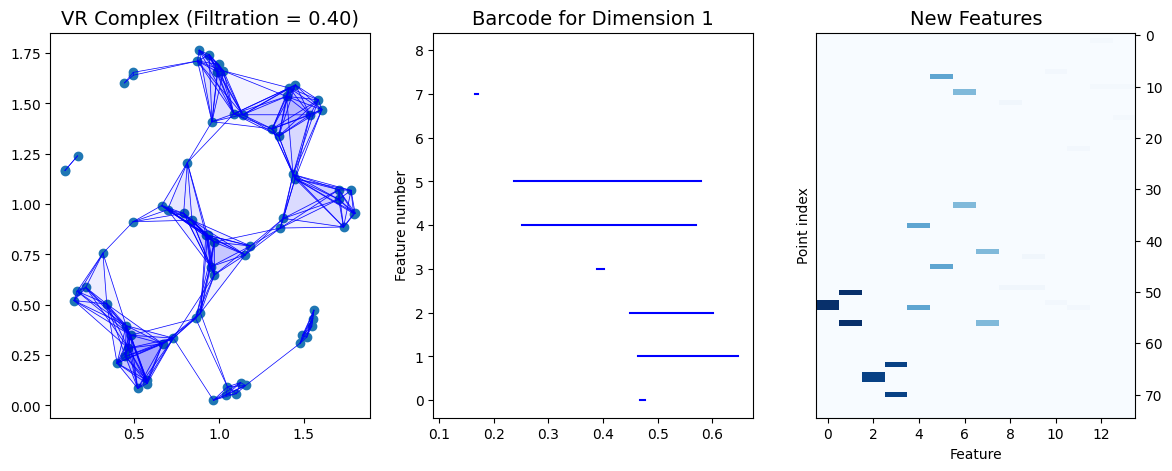

In [63]:
eps = 0.4
max_dim = 2
rips_complex = gd.RipsComplex(points=points, max_edge_length=eps)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)

fig, ax = plt.subplots(1, 3, figsize=(14, 5))

ax[0].scatter(points[:, 0], points[:, 1], label='Data Points')
ax[0].set_title(f'VR Complex (Filtration = {eps:.2f})', fontsize=14)
for simplex, _ in simplex_tree.get_skeleton(2):
    plot_simplex(simplex, ax[0], alpha=0.01)
        
# diag = simplex_tree.persistence(min_persistence=0.0, persistence_dim_max=max_dim)
# gd.plot_persistence_barcode(diag, axes=ax[1])  

plot_barcode(ax[1], result['dgms'], dimension=1)

ax[2].imshow(features[:, 2:], aspect='auto', cmap='Blues')
# ax[1].set_axis_off()
ax[2].set_xlabel('Feature')
ax[2].set_ylabel('Point index')
ax[2].set_title('New Features', fontsize=14)
ax[2].yaxis.tick_right()

plt.savefig('features.jpg')
plt.show()

In [282]:
# from concorde.tsp import TSPSolver

# eps = 0.33
# max_dim = 2
# rips_complex = gd.RipsComplex(points=points, max_edge_length=eps)
# simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)

# concorde_tour = TSPSolver.from_data(points[:, 0], points[:, 1], norm='GEO').solve(verbose=False).tour
# sequence_points_concorde = points[concorde_tour]
# sequence_points_concorde = np.vstack([sequence_points_concorde, sequence_points_concorde[0]])

# fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# ax[0].scatter(points[:, 0], points[:, 1])
# ax[1].set_title(f'VR Complex (Filtration = {eps:.2f})', fontsize=14)


# ax[1].scatter(points[:, 0], points[:, 1])
# ax[1].set_title('Data Points', fontsize=14)
# for simplex, _ in simplex_tree.get_skeleton(2):
#     plot_simplex(simplex, ax[1])
    
# axs[2].plot(sequence_points_concorde[:, 0], sequence_points_concorde[:, 1], marker='o', linestyle='-', color='blue')

In [139]:
fmt = '%s -> %.2f'
for filtered_value in simplex_tree.get_filtration():
    print(fmt % tuple(filtered_value))

[0] -> 0.00
[1] -> 0.00
[2] -> 0.00
[3] -> 0.00
[4] -> 0.00
[5] -> 0.00
[6] -> 0.00
[7] -> 0.00
[8] -> 0.00
[9] -> 0.00
[10] -> 0.00
[11] -> 0.00
[7, 11] -> 0.02
[2, 9] -> 0.09
[4, 5] -> 0.15
[1, 2] -> 0.17
[1, 9] -> 0.24
[1, 2, 9] -> 0.24
[2, 8] -> 0.24
[5, 11] -> 0.27
[6, 10] -> 0.27
[8, 9] -> 0.28
[2, 8, 9] -> 0.28
[5, 7] -> 0.28
[5, 7, 11] -> 0.28
[0, 3] -> 0.29
[3, 9] -> 0.31
[6, 7] -> 0.32
[0, 10] -> 0.33
[6, 11] -> 0.34
[6, 7, 11] -> 0.34
[6, 8] -> 0.35
[3, 8] -> 0.36
[3, 8, 9] -> 0.36
[1, 8] -> 0.36
[1, 2, 8] -> 0.36
[1, 8, 9] -> 0.36
[1, 2, 8, 9] -> 0.36
[8, 10] -> 0.37
[6, 8, 10] -> 0.37
[2, 3] -> 0.37
[2, 3, 8] -> 0.37
[2, 3, 9] -> 0.37
[2, 3, 8, 9] -> 0.37
[7, 8] -> 0.38
[6, 7, 8] -> 0.38
[8, 11] -> 0.39
[6, 8, 11] -> 0.39
[7, 8, 11] -> 0.39
[6, 7, 8, 11] -> 0.39
[3, 10] -> 0.39
[0, 3, 10] -> 0.39
[3, 8, 10] -> 0.39


In [59]:
file_path = "Checkpoints/checkpoint_10nodes_40epochs_graph_data.pkl"
checkpoint1 = torch.load(file_path)
file_path = "Checkpoints/checkpoint_10nodes_40epochs_base.pkl"
checkpoint2 = torch.load(file_path)

# loss_arr = checkpoint['loss_train']
# length_baseline = checkpoint['path_length_for_baseline']
# length_test = checkpoint['path_length_on_test']
# length_train = checkpoint['path_length_for_train']
gap_history1 = checkpoint1['gap_history']
gap_history2 = checkpoint2['gap_history']

In [44]:
file_path = "checkpoint_20nodes_what_epochs_graph_data.pkl"
checkpoint1 = torch.load(file_path)
file_path = "checkpoint_20nodes_200epochs_graph_data.pkl"
checkpoint2 = torch.load(file_path)

# loss_arr = checkpoint['loss_train']
# length_baseline = checkpoint['path_length_for_baseline']
# length_test = checkpoint['path_length_on_test']
# length_train = checkpoint['path_length_for_train']
gap_history1 = checkpoint1['gap_history']
gap_history2 = checkpoint2['gap_history']

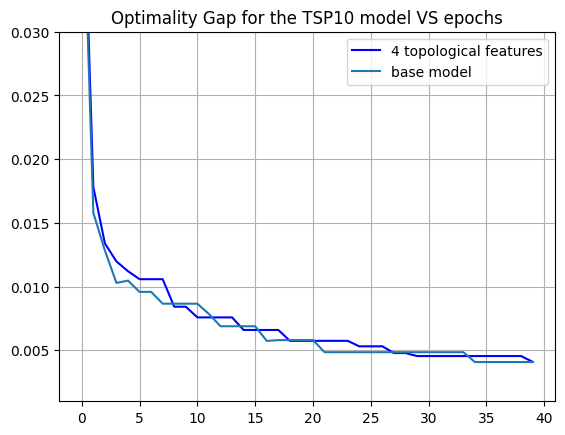

In [60]:
plt.plot([gap.numpy() for gap in gap_history1], label='4 topological features', color='b')
plt.plot([gap.numpy() for gap in gap_history2], label='base model')
# plt.yscale('log')
plt.ylim([1e-3, 0.03])
plt.title('Optimality Gap for the TSP10 model VS epochs')
plt.grid(True)
plt.legend()
plt.savefig('gap_10.jpg')
plt.show()

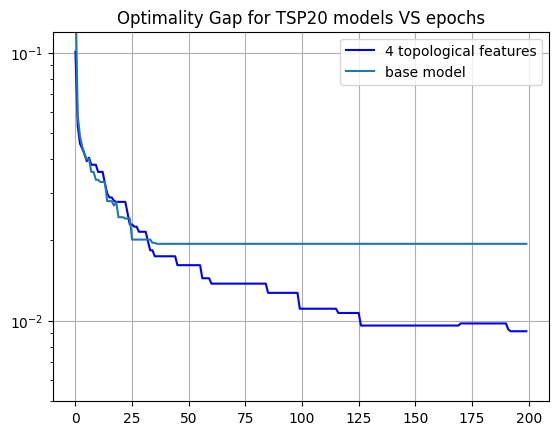

In [56]:
plt.plot([gap.numpy() for gap in gap_history1], label='4 topological features', color='b')
plt.plot([gap.numpy() for gap in gap_history2], label='base model')
plt.yscale('log')
plt.ylim([5e-3, 1.2e-1])
plt.title('Optimality Gap for TSP20 models VS epochs')
plt.grid(True)
plt.legend()
plt.savefig('gap_20.jpg')
plt.show()